<a href="https://colab.research.google.com/github/87tana/Brain_Tumor_Classification_Network_Comparison/blob/main/Brain_Tumor_Classification_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Miscellaneous
from tqdm import tqdm
import os
import random

## 2. Reading the Data

In [3]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])

    return data

### 2.1. Setting the Base Directory and Subdirectories:

In [4]:
image_data_paths = r"drive/MyDrive/Tumor_Classification/brain_tumor_dataset_train_test"
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")

train_data = shuffle(read_dataset(train_dir))
print(f'training image number: {len(train_data)}')

test_data = read_dataset(test_dir)
print(f'test image number: {len(test_data)}')

training image number: 2900
test image number: 394


In [5]:
train_data = pd.DataFrame(train_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_data.head(2)

,image_filepaths,tumor_class
0,drive/MyDrive/Tumor_Classification/brain_tumor...,meningioma
1,drive/MyDrive/Tumor_Classification/brain_tumor...,meningioma


In [6]:
test_data = pd.DataFrame(test_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_data.head(2)

,image_filepaths,tumor_class
0,drive/MyDrive/Tumor_Classification/brain_tumor...,glioma
1,drive/MyDrive/Tumor_Classification/brain_tumor...,pituitary


## 3. Data Visualization Distribution for each class

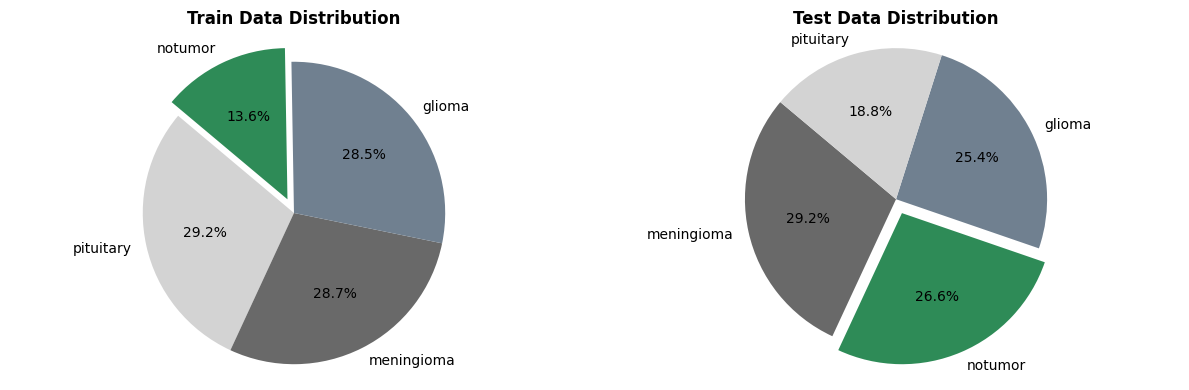

In [7]:
def create_pie_chart(ax, data, title, colors, explode):
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, weight='bold')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for train_data
label_counts_train = train_data['tumor_class'].value_counts().to_dict()
total_count_train = sum(label_counts_train.values())
label_percentages_train = {label: count / total_count_train * 100 for label, count in label_counts_train.items()}
colors_train = ['lightgray', 'dimgray', 'slategrey', 'seagreen']
explode_train = (0, 0, 0, 0.1)
create_pie_chart(axes[0], label_percentages_train, 'Train Data Distribution', colors_train, explode_train)

# Plot for test_data
label_counts_test = test_data['tumor_class'].value_counts().to_dict()
total_count_test = sum(label_counts_test.values())
label_percentages_test = {label: count / total_count_test * 100 for label, count in label_counts_test.items()}
colors_test = ['dimgray', 'seagreen', 'slategrey', 'lightgray']
explode_test = (0, 0.1, 0, 0)
create_pie_chart(axes[1], label_percentages_test, 'Test Data Distribution', colors_test, explode_test)

plt.tight_layout()
plt.show()


## 4. Splitting Training Data into Training and Validation Sets:

In [8]:
train_data, val_data = train_test_split(train_data,
                                               train_size = 0.85,
                                               random_state = 42,
                                               stratify = train_data.tumor_class)

In [9]:
print(train_data.shape),
print(val_data.shape),
print(test_data.shape)

(2465, 2)
(435, 2)
(394, 2)


## 5. Data Augmentation and Normalization(Rescaling)

- Image augmentation to **expand the image dataset** and **enhance the neural network's resilience to translation invariance**.



- This involves generating additional images by applying operations such as flipping, rotating, zooming, and adjusting brightness to the original dataset.

- Apply rescaling to all three datasets (train, validation, and test) for comparability. However, **limit data augmentation techniques **to the training dataset only, excluding the test and validation sets. This ensures that the model is evaluated on its ability to make predictions on unseen, unaltered data during the testing and validation phases.

In [10]:
image_size = 128
batch_size = 64

train_image_datagen_kwargs = dict(rescale = 1 / 255,
                                rotation_range = 15,
                                width_shift_range = 0.1,
                                zoom_range = 0.02,
                                shear_range = 0.01,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = "nearest"
                                )

test_image_datagen_kwargs = dict(rescale = 1 / 255)

## 6. Data Generator

In [11]:
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs) #generating batches of training data with augmentation.
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs) #generating batches of validation data without augmentation.
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of test data without augmentation.

- flow_from_dataframe allows you to apply these augmentations on-the-fly during training.

In [12]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        shuffle=False,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')


test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      shuffle=False,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 2465 validated image filenames belonging to 4 classes.
Found 435 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


## 7. Model Development

In [13]:
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 10)

- The "monitor" is like a metric that the callback keeps an eye on to see if things are getting better. In this situation, it's looking at 'val_accuracy,' which means it's checking how well the model is doing on the validation data.


- The "patience" is the number of epochs with no improvement after which training will be stopped. here, if the validation accuracy does not improve for 10 consecutive epochs, the training will be stopped.

- The EarlyStopping callback in Keras is used to stop training the neural network model when a monitored metric has stopped improving.

In [14]:
def model_def(base_model):

  # Set all layers to non-trainable
  for layer in base_model.layers:
      layer.trainable = False
  # Set the last block to trainable
  base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
  base_model.layers[-3].trainable = True
  base_model.layers[-4].trainable = True

  # build a custom model
  model = Sequential()
  model.add(Input(shape=(image_size,image_size,3)))
  model.add(base_model) #Adds the pre-trained base model to the model.
  model.add(Flatten())  #Flattens the output
  model.add(Dropout(0.3)) # 30% chance of being dropped out, helping to reduce overfitting.
  model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units
  model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
  model.add(Dense(4, activation='softmax'))

  return model

### 7.1 Development of VGG16

In [15]:
model_vgg = model_def(VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

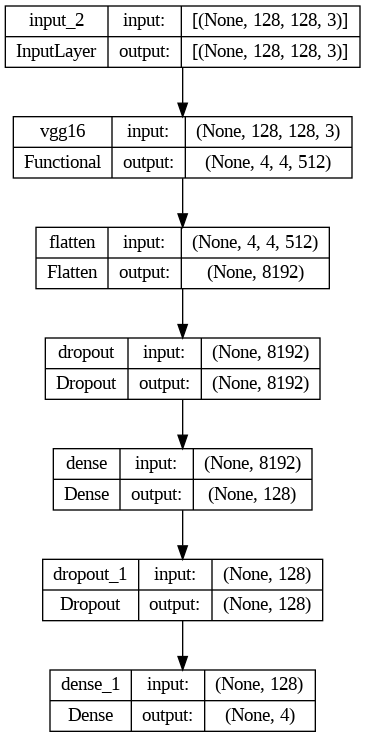

In [16]:
keras.utils.plot_model(model_vgg, show_shapes=True)

In [17]:
model_vgg.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [18]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_{epoch:02d}.hdf5"

model_vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [19]:
%%time
train_history_vgg = model_vgg.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_vgg_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 812s 20s/step - loss: 1.3469 - categorical_accuracy: 0.3606 - val_loss: 1.1612 - val_categorical_accuracy: 0.4368
Epoch 2/30
39/39 [==============================] - 24s 605ms/step - loss: 1.0711 - categorical_accuracy: 0.5132 - val_loss: 0.8824 - val_categorical_accuracy: 0.6161
Epoch 3/30
39/39 [==============================] - 23s 574ms/step - loss: 0.8512 - categorical_accuracy: 0.6243 - val_loss: 0.7394 - val_categorical_accuracy: 0.6828
Epoch 4/30
39/39 [==============================] - 23s 578ms/step - loss: 0.7851 - categorical_accuracy: 0.6807 - val_loss: 0.6909 - val_categorical_accuracy: 0.7517
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.7000 - categorical_accuracy: 0.7284
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_05.hdf5
39/39 [==============================] - 26s 669ms/step - loss: 0.6947 - categorical_accuracy: 0.7306 - val_loss: 0.5461 - val_cat

In [20]:
print(train_history_vgg.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


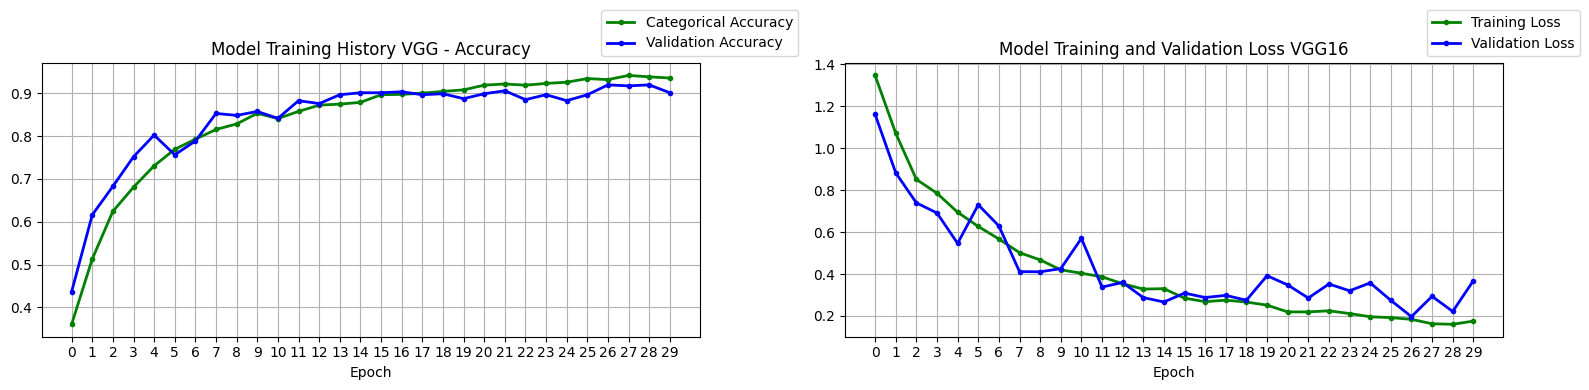

In [21]:
# Plot train vs Validation Accuracy
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(train_history_vgg.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history_vgg.history['val_categorical_accuracy'], '.b-', linewidth=2, label='Validation Accuracy')
plt.title('Model Training History VGG - Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_vgg.history['categorical_accuracy'])))
plt.legend(loc='lower center', bbox_to_anchor=(1, 1))

# Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(train_history_vgg.history['loss'], '.g-', label='Training Loss', linewidth=2)

if 'val_loss' in train_history_vgg.history:
    plt.plot(train_history_vgg.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss VGG16')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_vgg.history['loss'])))
plt.legend(loc='lower center', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()



In [27]:
test_epoch = '20'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_"+test_epoch+".hdf5"
model_vgg.load_weights(weights_path)

In [28]:
# Evaluate the model on the test set for VGG16
evaluation_results_vgg = model_vgg.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_vgg[0]}')
print(f'Test Accuracy: {evaluation_results_vgg[1]}')

7/7 [==============================] - 2s 201ms/step - loss: 1.4915 - categorical_accuracy: 0.7107
Test Loss: 1.4915361404418945
Test Accuracy: 0.710659921169281


In [29]:
y_perd_vgg = model_vgg.predict(test_dataset)

7/7 [==============================] - 1s 177ms/step


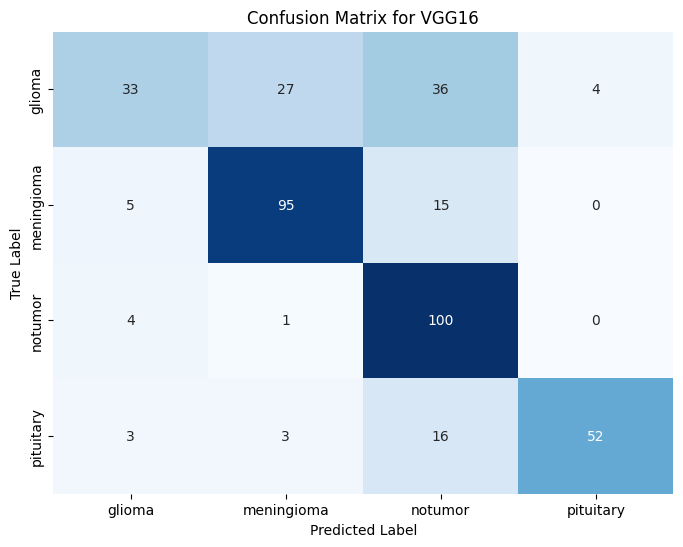

In [30]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix for VGG16
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_vgg,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VGG16')
plt.show()

In [31]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_vgg,axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.33      0.46       100
           1       0.75      0.83      0.79       115
           2       0.60      0.95      0.74       105
           3       0.93      0.70      0.80        74

    accuracy                           0.71       394
   macro avg       0.75      0.70      0.69       394
weighted avg       0.74      0.71      0.69       394



### 7.2 Development of Xception model

In [32]:
model_xception =  model_def(Xception(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_xception.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

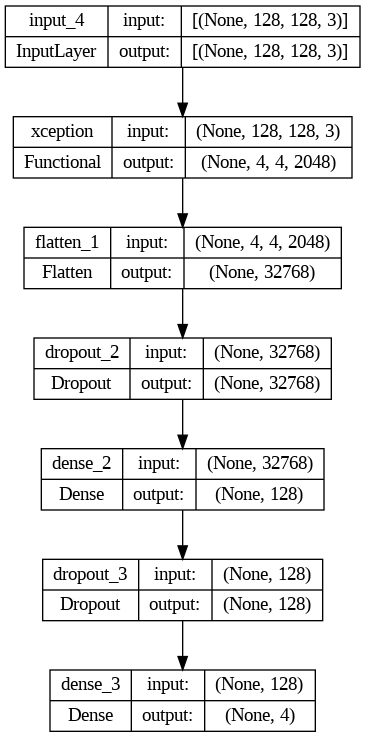

In [33]:
keras.utils.plot_model(model_xception, show_shapes=True)

In [34]:
model_xception.compile(optimizer=Adam(learning_rate = 0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [35]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_{epoch:02d}.hdf5"

model_xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [36]:
%%time
train_history_xception = model_xception.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_xception_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 30s 615ms/step - loss: 0.8668 - categorical_accuracy: 0.6576 - val_loss: 0.6687 - val_categorical_accuracy: 0.7517
Epoch 2/30
39/39 [==============================] - 22s 557ms/step - loss: 0.5797 - categorical_accuracy: 0.7753 - val_loss: 0.4943 - val_categorical_accuracy: 0.8069
Epoch 3/30
39/39 [==============================] - 24s 611ms/step - loss: 0.5171 - categorical_accuracy: 0.8028 - val_loss: 0.4331 - val_categorical_accuracy: 0.8230
Epoch 4/30
39/39 [==============================] - 23s 589ms/step - loss: 0.4620 - categorical_accuracy: 0.8260 - val_loss: 0.4615 - val_categorical_accuracy: 0.8069
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.4274 - categorical_accuracy: 0.8388
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_05.hdf5
39/39 [==============================] - 26s 673ms/step - loss: 0.4261 - categorical_accuracy: 0.8398 - val_loss: 0.3955 - v

In [55]:
print(train_history_xception.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


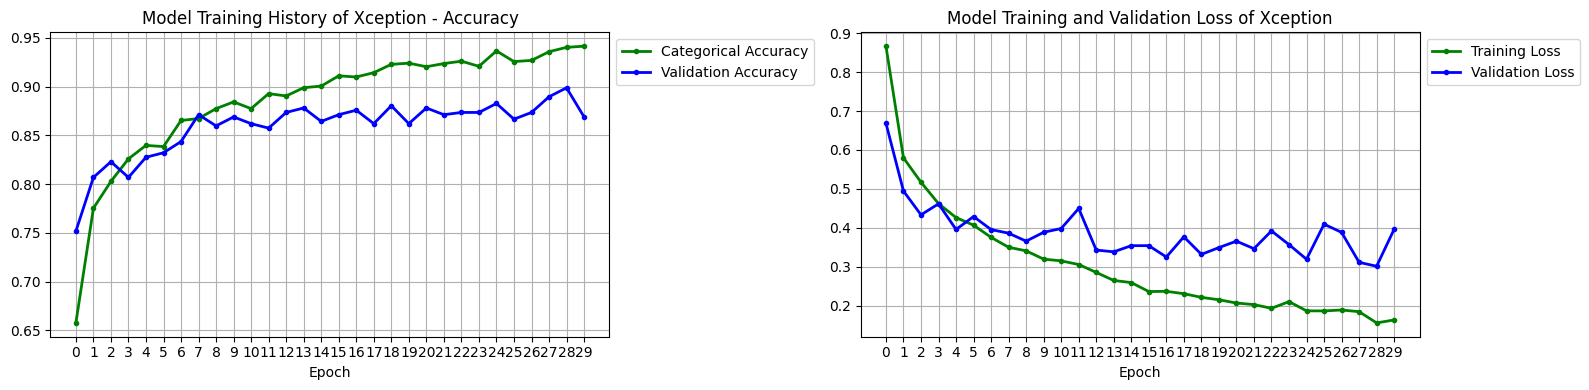

In [56]:
# Plot Categorical Accuracy and Validation Accuracy
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(train_history_xception.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history_xception.history['val_categorical_accuracy'], '.b-', linewidth=2, label='Validation Accuracy')
plt.title('Model Training History of Xception - Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_xception.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(train_history_xception.history['loss'], '.g-', label='Training Loss', linewidth=2)

if 'val_loss' in train_history_xception.history:
    plt.plot(train_history_xception.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss of Xception')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history_xception.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [57]:
test_epoch = '25'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_"+test_epoch+".hdf5"
model_xception.load_weights(weights_path)

In [ ]:
test_epoch = '25'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_"+test_epoch+".hdf5"
model_xception.load_weights(weights_path)

In [58]:


# Evaluate the model on the test set
evaluation_results_xception = model_xception.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_xception[0]}')
print(f'Test Accuracy: {evaluation_results_xception[1]}')

7/7 [==============================] - 1s 162ms/step - loss: 1.8409 - categorical_accuracy: 0.6853
Test Loss: 1.8409065008163452
Test Accuracy: 0.6852791905403137


In [59]:
y_perd_xception = model_xception.predict(test_dataset)

7/7 [==============================] - 1s 183ms/step


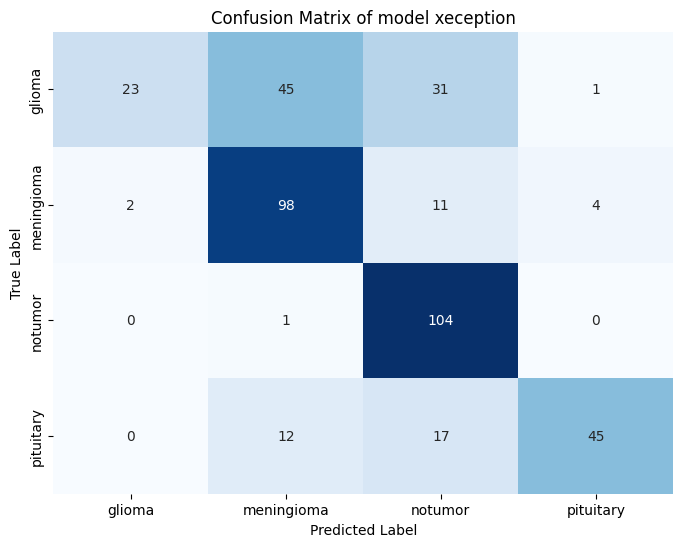

In [60]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_xception,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix of xception
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of model xeception')
plt.show()

In [61]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_xception,axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.23      0.37       100
           1       0.63      0.85      0.72       115
           2       0.64      0.99      0.78       105
           3       0.90      0.61      0.73        74

    accuracy                           0.69       394
   macro avg       0.77      0.67      0.65       394
weighted avg       0.76      0.69      0.65       394



## 8.3 Development of MobileNet

In [62]:
model_MobileNet =  model_def(MobileNet(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_MobileNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_6 (Dropout)         (None, 16384)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               2097280   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                      

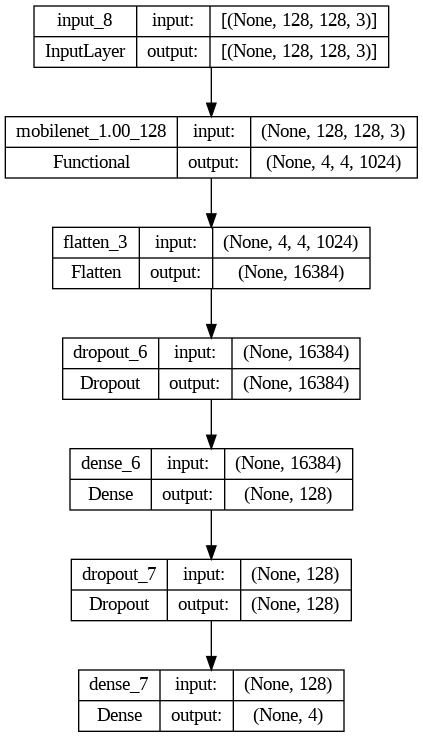

In [63]:
keras.utils.plot_model(model_MobileNet, show_shapes=True)

In [64]:
model_MobileNet.compile(optimizer=Adam(learning_rate=0.00001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [66]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_{epoch:02d}.hdf5"

model_MobileNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [67]:
%%time
train_history_MobileNet = model_MobileNet.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_MobileNet_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 27s 604ms/step - loss: 2.0887 - categorical_accuracy: 0.3533 - val_loss: 1.1689 - val_categorical_accuracy: 0.5310
Epoch 2/30
39/39 [==============================] - 21s 541ms/step - loss: 1.3704 - categorical_accuracy: 0.4901 - val_loss: 0.9116 - val_categorical_accuracy: 0.6391
Epoch 3/30
39/39 [==============================] - 23s 579ms/step - loss: 1.0895 - categorical_accuracy: 0.5874 - val_loss: 0.8252 - val_categorical_accuracy: 0.6805
Epoch 4/30
39/39 [==============================] - 21s 534ms/step - loss: 0.9701 - categorical_accuracy: 0.6434 - val_loss: 0.8050 - val_categorical_accuracy: 0.6874
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 0.8529 - categorical_accuracy: 0.6722
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_05.hdf5
39/39 [==============================] - 23s 581ms/step - loss: 0.8540 - categorical_accuracy: 0.6706 - val_loss: 0.6941 - 

In [68]:
print(train_history_MobileNet.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


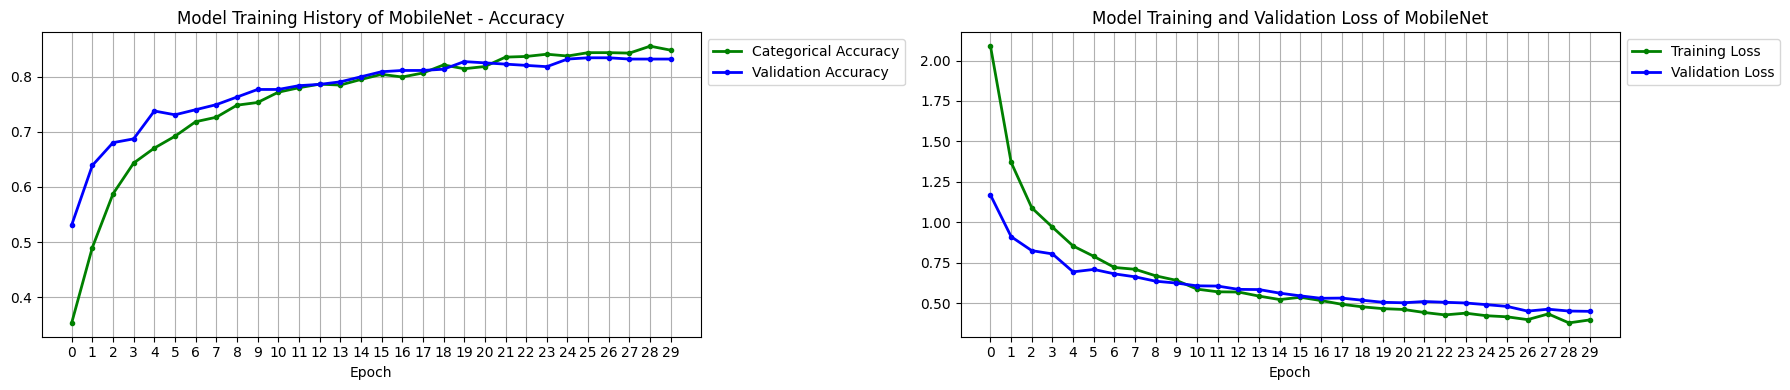

In [69]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_MobileNet.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_MobileNet.history['val_categorical_accuracy'], '.b-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History of MobileNet - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_xticks(range(len(train_history_MobileNet.history['categorical_accuracy'])))
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot Training Loss and Validation Loss
axes[1].grid(True)
axes[1].plot(train_history_MobileNet.history['loss'], '.g-', label='Training Loss', linewidth=2)

if 'val_loss' in train_history_MobileNet.history:
    axes[1].plot(train_history_MobileNet.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

axes[1].set_title('Model Training and Validation Loss of MobileNet')
axes[1].set_xlabel('Epoch')
axes[1].set_xticks(range(len(train_history_MobileNet.history['loss'])))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()



In [85]:
test_epoch = '25'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_"+test_epoch+".hdf5"
model_MobileNet.load_weights(weights_path)

In [86]:
# Evaluate the model on the test set
evaluation_results_MobileNet = model_MobileNet.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_MobileNet[0]}')
print(f'Test Accuracy: {evaluation_results_MobileNet[1]}')

7/7 [==============================] - 1s 169ms/step - loss: 1.2730 - categorical_accuracy: 0.5787
Test Loss: 1.273014783859253
Test Accuracy: 0.5786802172660828


In [87]:
y_perd_MobileNet = model_MobileNet.predict(test_dataset)

7/7 [==============================] - 1s 199ms/step


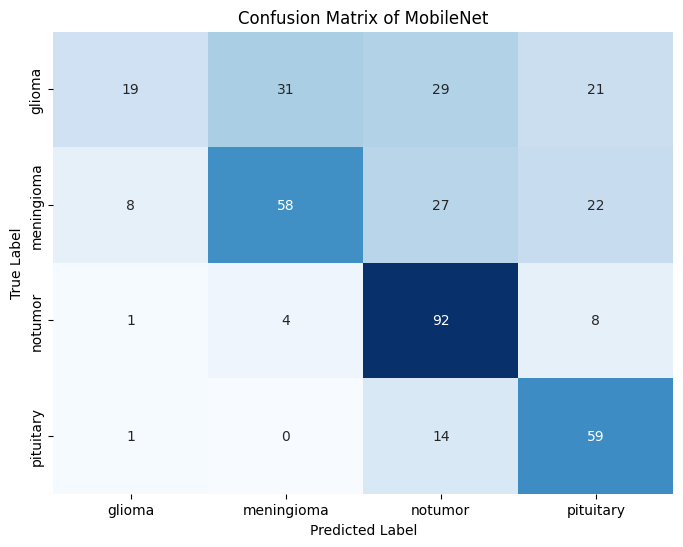

In [88]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of MobileNet
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_MobileNet,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix of MobileNet
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MobileNet')
plt.show()

In [89]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_MobileNet,axis=1)))

              precision    recall  f1-score   support

           0       0.66      0.19      0.29       100
           1       0.62      0.50      0.56       115
           2       0.57      0.88      0.69       105
           3       0.54      0.80      0.64        74

    accuracy                           0.58       394
   macro avg       0.60      0.59      0.55       394
weighted avg       0.60      0.58      0.54       394



# 7.4 Development of ReseNet50

In [90]:
model_ResNet50 =  model_def(ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_ResNet50.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_8 (Dropout)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                       

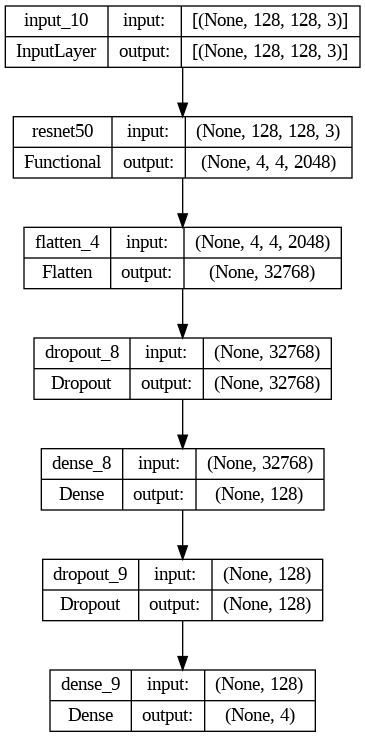

In [91]:
keras.utils.plot_model(model_ResNet50, show_shapes=True)

In [92]:
model_ResNet50.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [93]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_{epoch:02d}.hdf5"

model_ResNet50_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [94]:
%%time
train_history_ResNet50 = model_ResNet50.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_ResNet50_checkpoint_callback])

Epoch 1/30
39/39 [==============================] - 31s 658ms/step - loss: 1.9551 - categorical_accuracy: 0.3347 - val_loss: 1.3199 - val_categorical_accuracy: 0.2989
Epoch 2/30
39/39 [==============================] - 22s 577ms/step - loss: 1.2629 - categorical_accuracy: 0.4239 - val_loss: 1.2751 - val_categorical_accuracy: 0.4460
Epoch 3/30
39/39 [==============================] - 28s 717ms/step - loss: 1.2200 - categorical_accuracy: 0.4365 - val_loss: 1.2277 - val_categorical_accuracy: 0.5310
Epoch 4/30
39/39 [==============================] - 26s 678ms/step - loss: 1.1736 - categorical_accuracy: 0.4495 - val_loss: 1.1478 - val_categorical_accuracy: 0.5333
Epoch 5/30
38/39 [============================>.] - ETA: 0s - loss: 1.1509 - categorical_accuracy: 0.4611
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_05.hdf5
39/39 [==============================] - 30s 765ms/step - loss: 1.1494 - categorical_accuracy: 0.4617 - val_loss: 1.1202 - v

In [95]:
print(train_history_ResNet50.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


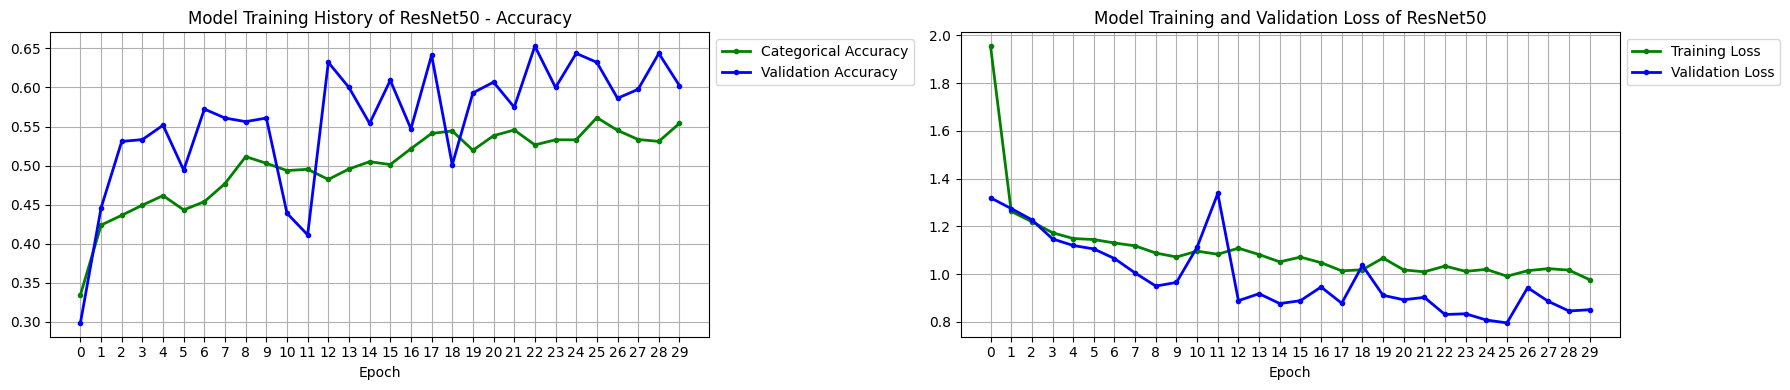

In [96]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_ResNet50.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_ResNet50.history['val_categorical_accuracy'], '.b-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History of ResNet50 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_xticks(range(len(train_history_ResNet50.history['categorical_accuracy'])))
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot Training Loss and Validation Loss
axes[1].grid(True)
axes[1].plot(train_history_ResNet50.history['loss'], '.g-', label='Training Loss', linewidth=2)

if 'val_loss' in train_history_ResNet50.history:
    axes[1].plot(train_history_ResNet50.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

axes[1].set_title('Model Training and Validation Loss of ResNet50')
axes[1].set_xlabel('Epoch')
axes[1].set_xticks(range(len(train_history_ResNet50.history['loss'])))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [97]:
test_epoch = '15'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_"+test_epoch+".hdf5"
model_ResNet50.load_weights(weights_path)

In [98]:
# Evaluate the model on the test set
evaluation_results_ResNet50 = model_ResNet50.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_ResNet50[0]}')
print(f'Test Accuracy: {evaluation_results_ResNet50[1]}')

7/7 [==============================] - 2s 252ms/step - loss: 2.2162 - categorical_accuracy: 0.2817
Test Loss: 2.216248035430908
Test Accuracy: 0.2817258834838867


In [99]:
y_perd_ResNet50 = model_ResNet50.predict(test_dataset)

7/7 [==============================] - 2s 189ms/step


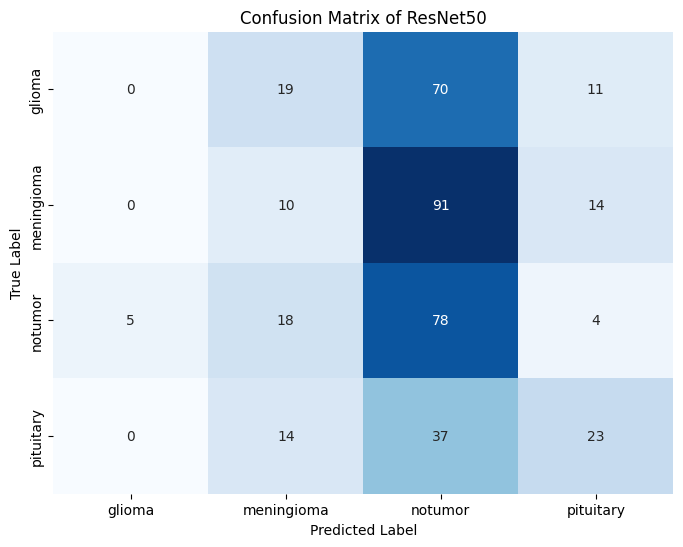

In [100]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of ResNet50
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of ResNet50')
plt.show()

In [101]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.16      0.09      0.11       115
           2       0.28      0.74      0.41       105
           3       0.44      0.31      0.37        74

    accuracy                           0.28       394
   macro avg       0.22      0.29      0.22       394
weighted avg       0.21      0.28      0.21       394



## Model Analysis and Comparison

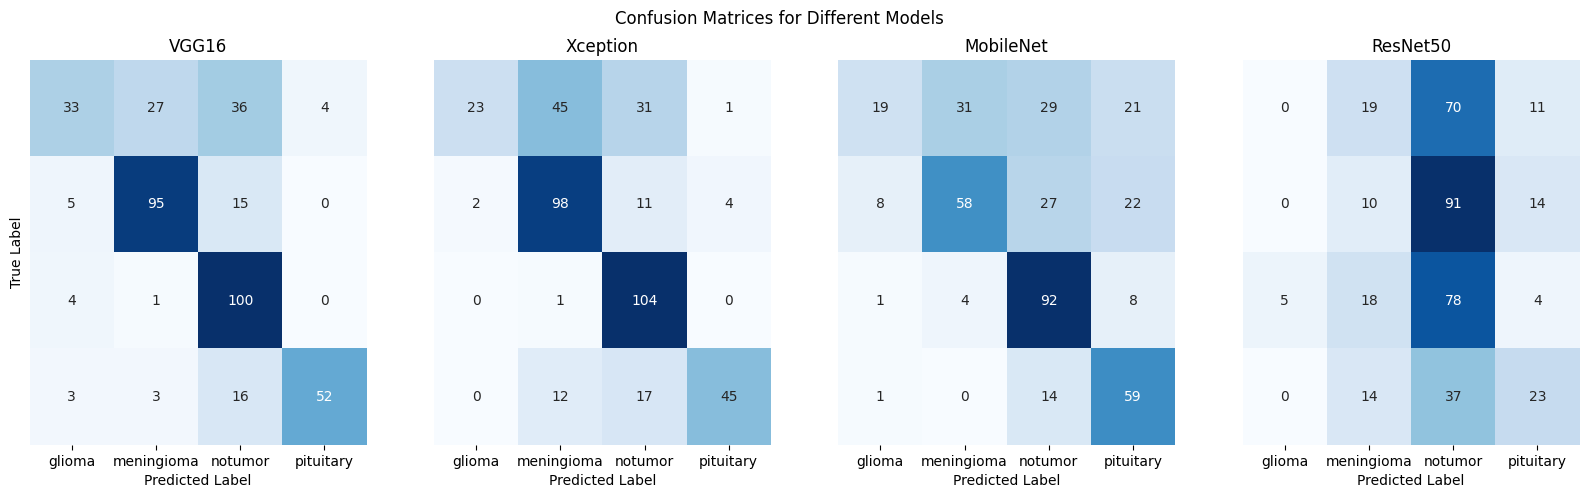

In [102]:
unique_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix for VGG16
conf_matrix_vgg = confusion_matrix(test_dataset.labels, np.argmax(y_perd_vgg, axis=-1))
conf_matrix_data_vgg = np.array(conf_matrix_vgg)

# Confusion matrix for Xception
conf_matrix_xception = confusion_matrix(test_dataset.labels, np.argmax(y_perd_xception, axis=-1))
conf_matrix_data_xception = np.array(conf_matrix_xception)

# Confusion matrix for MobileNet
conf_matrix_mobileNet = confusion_matrix(test_dataset.labels, np.argmax(y_perd_MobileNet, axis=-1))
conf_matrix_data_mobileNet = np.array(conf_matrix_mobileNet)

# Confusion matrix for ResNet50
conf_matrix_resNet50 = confusion_matrix(test_dataset.labels, np.argmax(y_perd_ResNet50, axis=-1))
conf_matrix_data_resNet50 = np.array(conf_matrix_resNet50)

# Plotting the confusion matrices side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# VGG16
sns.heatmap(conf_matrix_data_vgg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('VGG16')

# Xception
sns.heatmap(conf_matrix_data_xception, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=[], ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_title('Xception')

# MobileNet
sns.heatmap(conf_matrix_data_mobileNet, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=[], ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_title('MobileNet')

# ResNet50
sns.heatmap(conf_matrix_data_resNet50, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels, yticklabels=[], ax=axes[3])
axes[3].set_xlabel('Predicted Label')
axes[3].set_title('ResNet50')

plt.suptitle('Confusion Matrices for Different Models')
plt.show()


- The diagonal elements represent correctly predicted instances (True Positives).


- Off-diagonal elements represent misclassifications (False Positives and False Negatives).


- The higher the diagonal values of the confusion matrix, the better the model's performance.


- The values on the diagonal of the confusion matrix represent the number of correctly classified instances for each class.

**Observation:**


- For Glioma (Class 0): The model correctly identified 391 instances of Glioma (TP), but there were X instances misclassified as other classes ('meningioma', 'notumor', or 'pituitary').


- For Meningioma (Class 1): The model correctly identified 1355 instances of Meningioma (TP), and there was X misclassification.



- No Tumor (Class 2):The model correctly identified 1305 instances of No Tumor (TP), and there was  X misclassification.



- Pituitary (Class 3) : The model correctly identified 767 instances of Pituitary (TP), but there were 19 instances misclassified as other classes.



- In conclusion, The model has a noticeable number of misclassifications, especially in the 'glioma' class (Class 0) and the 'pituitary' class (Class 3).



- Further analysis, such as examining precision, recall, and F1-score for each class, could provide a more comprehensive evaluation of the model's strengths and weaknesses. Additionally, fine-tuning the model, adjusting hyperparameters, or using more advanced architectures may help improve performance.
